## Introduction
This notebook will look into what collaborative filtering is, why it is used, how to use it, and how to implement it from scratch and using libraries.


In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import torch
import numpy as np
import pandas as pd

## Why Collaborative Filtering?

When there is a problem of recommending things to people, collaborative filtering works to solve that problem. It works by taking taking products one user likes and matches it with another user who also likes similar products, and then recommends other products the matched user likes.

The key foundational idea around collaborative filtering is the concept of latent factors, which can be described as embedding or numbers around a product that draw certain users to enjoy that product. 

We are going to explore this topic through the movie recommendation problem.

In [4]:
from fastai.collab import *
from fastai.tabular.all import *

There is a great dataset of movie recommendations with around 100,000 movies that we can expirement on and explore.

In [5]:
path = untar_data(URLs.ML_100k)

The data is tab seperated  and the columns are user, movie, rating, and timestamp. 

In [8]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                     names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


![img](table.png)

The purpose of collaborative filtering is to fill in these gaps between the users and movies. The reason why is that these are movies the user has not watched and if we can predict which movies they would most likely predict highly, we can recommend those movies to that users.

The way to do this is to provide numbers describing a movie and users preferences such as having +1 or -1 depending on the factor.

For example: these categories would be if the movie is about or user enjoys: science-fiction, action, and old movies

In [9]:
last_skywalker = np.array([0.98, 0.9, -0.9])

In [10]:
user1 = np.array([0.9, 0.8, -0.6])

This is saying that The Last Skywalker is a science-fiction movie, it has lots of action, and is not that old of a movie. 

It is also saying that the user likes science-fiction movies, like action movies, and doesn't like old movies that much.

Therefore, if we calculate a match between the movie and the user, we should get a relatively high number.

In [11]:
(user1*last_skywalker).sum()

2.1420000000000003

We took the dot product of the two vectors in order to calculate the match between the two.

## Latent Factors

The numbers that we set to the user and movies are called latent factors. We can set an arbitrary amount of numbers for latent factors, but in the end they are used the describe the movie and the user. The dot product of these latent factors, in this case, will be the prediction rating the user gives to the movie.

The steps to calculate the correct latent factors can be done using stochastic gradient descent.

Step 1: Randomly initialize random latent factor values for each movie and user.
Step 2: Take the dot product of each movie with each user to calculate a prediction
Step 3: Calculate the loss by using our prediction and the actual prediction
Step 4: Optimize based on the loss

## Creating Dataloaders

In [79]:
#This gets the Movie ID and the Movie Title
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                    usecols=(0,1), names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [80]:
# Combine the ratings with the movies
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


Using Fast.ai, we can build a Dataloaders object from this table.

In [81]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,455,"Spitfire Grill, The (1996)",5
1,246,Pulp Fiction (1994),1
2,459,Four Rooms (1995),2
3,442,Star Trek III: The Search for Spock (1984),3
4,360,Jerry Maguire (1996),4
5,928,It's a Wonderful Life (1946),5
6,256,Full Metal Jacket (1987),5
7,224,Disclosure (1994),3
8,487,Batman Returns (1992),1
9,405,Stargate (1994),1


Now to create our latent factors we need tensors for the movies and the users. 

We calculate the latent factors by taking the amount of users and movies and implementing random numbers for the amount of latent factors. We have arbitrarily chosen 5 for this value.

In [82]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

A problem with models is that they are unable to index and we need that so we can look up the index of a movie or user in our latent factor matrices. Luckily we can encode a one hot vector with index and take the matrix product in order to index a user or movie.

In [20]:
one_hot_3 = one_hot(3, n_users).float()

In [32]:
one_hot_3.shape

torch.Size([944])

In [31]:
user_factors.t().shape

torch.Size([5, 944])

In [34]:
user_factors.t()@one_hot_3

tensor([-0.7864,  0.9075,  1.5646,  0.1570, -0.5177])

In [33]:
user_factors[3]

tensor([-0.7864,  0.9075,  1.5646,  0.1570, -0.5177])

Notice they both have the same output.

But rather than creating one-hot encoded vectors, we can create a matrix of embeddings which represent the numbers that characterize each user and movie. The great thing is that we don't need to know what each number represents since the model can learn  them by analyzing the existing relations between the users and the movie and determine itself which features seem important or not.

## From Scratch

In [49]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users*movies).sum(dim=1)
        

Here we want to create a module that takes in the number of users, movies, and latent factors and create an Embedding for them.

Then when we want to move the layer forward we want to take the dot product of the to embeddings.

In [50]:
x, y = dls.one_batch()
x.shape

torch.Size([64, 2])

Now that we have our parameter matrices, we need to create a Learner that will optimize our model.

In [51]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [52]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.305319,1.321458,00:04
1,1.066962,1.087329,00:04
2,0.938822,0.976138,00:04
3,0.811355,0.899348,00:04
4,0.759719,0.880791,00:04


The first thing we can do to improve our model is to force the predictions between 0 and 5. The reason is because those are our max predictions.

We can do this by using the `sigmoid_range` and using the range `(0, 5.5)`. The reason we use 5.5 is because it never sigmoid never reaches 1 or in this case 5, so we want to use a slightly higher top range.

In [60]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range= y_range

    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        return sigmoid_range((users*movies).sum(dim=1), *self.y_range)

In [61]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.011800,1.006575,00:04
1,0.865396,0.912627,00:04
2,0.691703,0.875875,00:04
3,0.487135,0.883337,00:04
4,0.357841,0.887203,00:04


It did around the same, but we can do better. 

We can improve this model by adding biases. Objectively, some users will like movies less and some will like more. This is similar to movies, some will be objectively better and more liked and some are not liked at all even by those who enjoy the genre. We can add this bias into the model by creating singular embedding for the bias to account for this.

In [83]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range= y_range

    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        res = (users*movies).sum(dim=1, keepdim=True)     
        res += self.user_bias(x[:, 0]) + self.movie_bias(x[:, 1])
        return sigmoid_range(res, *self.y_range)

In [84]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.908446,0.946999,00:04
1,0.803615,0.874721,00:04
2,0.621487,0.867619,00:04
3,0.411512,0.893405,00:04
4,0.293098,0.900004,00:04


Notice how initially we were improving our loss until it suddenly got worse again. This is a sign that we are overfitting.

In this case, we are unable to use other overfitting techniques such as data augmentation. So we can use another regularization technique called weight decay also known as `L2 Regularization`.

## Weight Decay

L2 regularization consists of adding the sum of all the weights squared to the loss function. 

Why would this prevent overfitting? The idea is that the larger the coefficients are, the more narrow the canyons of loss are in the loss functions. As a result, it may be prone to overfitting due the sharp changes in loss.

Therefore, in order to prevent this we limit our weights from growing too much by adding weight decay which can lead to a more generalized state of the model.

In [85]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.918322,0.967041,00:04
1,0.834799,0.885202,00:04
2,0.724392,0.843343,00:04
3,0.574966,0.831643,00:04
4,0.493969,0.832477,00:04


The model did much better now!

## Creating our own Embedding Module

So far, we utilized the `Embedding` module as a black box. We are going to recreate it so we can understanding how the Embedding Module really works.

In order to create an embedding matrix, we need a randomly initialize weight matrix for each of the embeddings. We also need to make sure the Learner knows these are parameters to be optimized so we need to wrap the in the `Parameter Class`. It doesn't add any new functionality but gives it an attribute the model knows.

In [86]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [87]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0,0.01))

This class creates a parameter matrix of `size` with a gaussian distribution parameterized by `0, 0.01`.

Now we can recreate the `DotProductBias` model without `Embedding`.

In [89]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [90]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.936474,0.963015,00:04
1,0.850228,0.878349,00:04
2,0.738113,0.840014,00:05
3,0.575747,0.828917,00:04
4,0.470256,0.829888,00:04


## Interpretting Embeddings and Biases

The model now can give us prediction on movies based on the users, but it looking deeply at the parameters we can find some interesting information.

For example movies that now have a low bias embedding means that these movies weren't really liked by anyone and vice versa.

In [97]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Crow: City of Angels, The (1996)',
 'Robocop 3 (1993)',
 'Barb Wire (1996)']

In [98]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'Titanic (1997)',
 'Star Wars (1977)',
 'Silence of the Lambs, The (1991)']

There are other ways to look at embeddings and that is by conducting a principal component analysis. This pulls out the most important underlying directions in a matrix

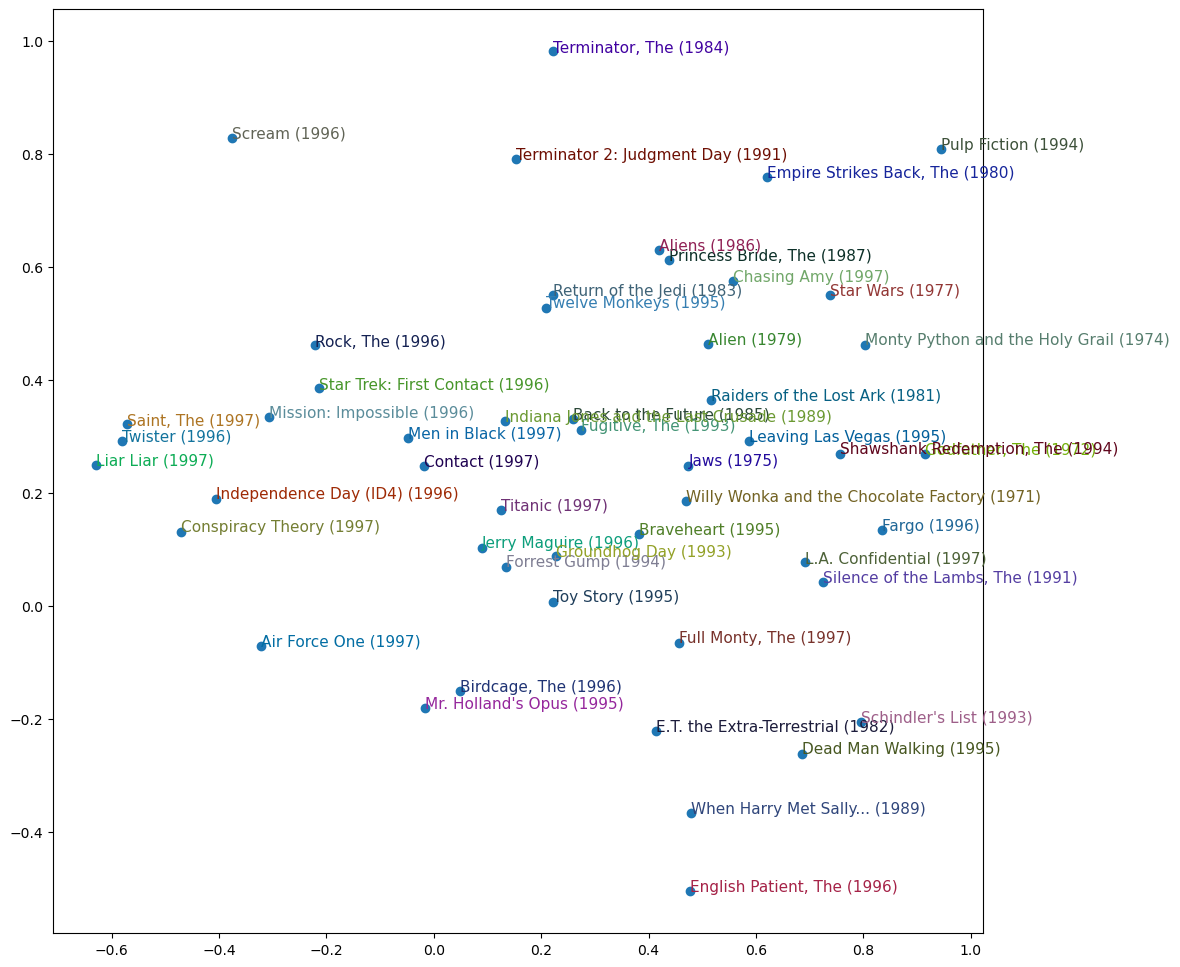

In [99]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

As you can see, movies that are generally similar are shown to be in the same area.

### Using Fast.ai

We can do everything faster by using a library such as fast.ai to do the bulk of the work for us using collab_learner.

In [104]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [105]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.000430,0.965530,00:04
1,0.860607,0.882545,00:04
2,0.734349,0.838787,00:04
3,0.628241,0.826765,00:04
4,0.477939,0.828091,00:04


In [106]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

As we can see, it created a similar model to that we created before from scratch.

## Deep learning for Collaborative Filtering

Currently our model is a simple dot product of embeddings and a opitmization from stochatstic gradient descent. We can extend this architecture to a deep learning model by concatinating the embeeding and activations together and pass them through linear and nonlinearities in the usual way.

Since we are concatinating the embeddings and not taking the dot product, this means that we can have different sizes for the embeddings for the users and movies. We can use fast.ai for a recomendation on the embedding layer size.

In [124]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [128]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act), # Create a Linear Layer of the input user and movie embeddinhg size with n_act output activations 
            nn.ReLU(), # Put it throw a ReLU
            nn.Linear(n_act, 1)) # Linear Layer to put it to one output
        self.y_range = y_range

    def forward(self, x):
        embs = self.user_factors(x[:, 0]), self.item_factors(x[:, 1]) # Get the embeddings
        x = self.layers(torch.cat(embs, dim=1)) # Concatinate the embeddings from the layers 
        return sigmoid_range(x, *self.y_range) # Get the sigmoid of the embeddings

In [129]:
model = CollabNN(*embs)

In [130]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.951665,0.946877,00:07
1,0.892001,0.927861,00:07
2,0.838990,0.885077,00:07
3,0.814148,0.871359,00:07
4,0.764098,0.875821,00:07


CollabNN creates a mini-neural network that has a forward where were apply the embeddings, concatenate the results, and pass this through the mini-neural net. Then we apply the sigmoid range

We can also pass more layers in the neural net with fast.ai.

Here we are creating a neural network with two extra layers of 100 and 50.

In [135]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.997483,0.975779,00:08
1,0.910320,0.937211,00:08
2,0.880771,0.897695,00:08
3,0.806628,0.870326,00:08
4,0.773416,0.865377,00:08


## Conclusion

We looked at recommendation systems using Collaborative Filtering. 

It was interesting to see that that many models follow the same underlying principals such as gradient descent and optimizing weights and biases. We were also able to understand the concept of embedding and how they are useful in being able to numerically describe the similarity between data that are not numerical by nature. Using that knowledge, we were able to create a deep learning model that was able to optimize these embeddings in order to get accurate predictions.